# Late robustness

During the model training, we activate the robustness term only after the model expresses the basic topology of the data
In the robustness phase the decision boundaries are then diffused and robustified

In [1]:
import torch
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

56



# Data preparation

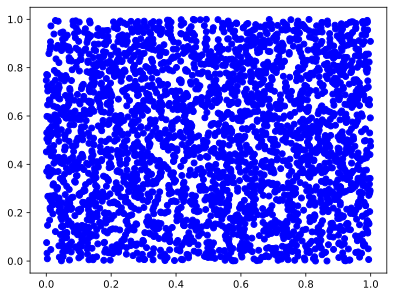

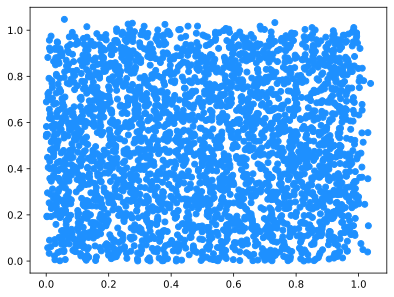

No change applied to TS or repr data


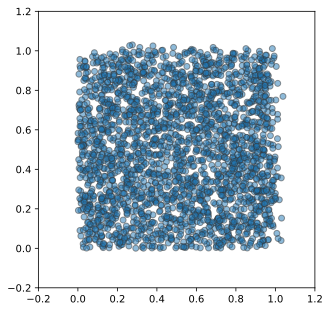

In [2]:
data_noise = 0.02
plotlim = [-0.2, 1.2]
subfolder = 'traj_TS'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('TS', noise = data_noise, plotlim = plotlim, random_state = seed, label = 'vector')


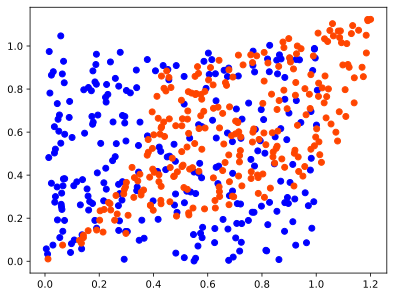

x = tensor([[0.8061, 0.6582],
        [0.1304, 0.2620],
        [0.0942, 0.0409],
        [0.0448, 0.3452],
        [0.3002, 0.7934]])
y = tensor([[1.0090, 0.8275],
        [0.3635, 0.3311],
        [0.1342, 0.0840],
        [0.2967, 0.3454],
        [0.6693, 0.8172]])


In [3]:
for X_viz, y_viz in dataloader_viz:
    plt.scatter(X_viz[:,0], X_viz[:,1], c='b')
    plt.scatter(y_viz[:,0], y_viz[:,1], c='orangered')
    plt.show()
    X_viz = X_viz[0:5]
    print('x =', X_viz)
    y_viz = y_viz[0:5]
    print('y =', y_viz)
    break

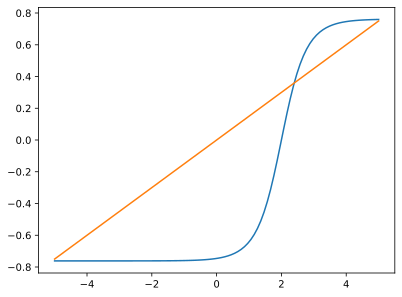

In [5]:
x_vec = np.linspace(-5,5,100)
tanh2_x = np.tanh(np.tanh(x_vec - 2))
plt.plot(x_vec, tanh2_x)
plt.plot(x_vec, 0.15*x_vec)
plt.show()

In [ ]:
S**n/(S**n + np.matmul(A,x_vec)**n)

## Model dynamics

In [18]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 20, 20
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = False
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside

## Training and generating level sets

In [19]:

num_epochs = 80 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

In [20]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
# verbose = True for more details
trainer_anode.train(dataloader, num_epochs)


Iteration 0/38
Loss: 1.731

Iteration 10/38
Loss: 1.578

Iteration 20/38
Loss: 1.331

Iteration 30/38
Loss: 1.057
Epoch 1: 1.248

Iteration 0/38
Loss: 0.547

Iteration 10/38
Loss: 0.428

Iteration 20/38
Loss: 0.317

Iteration 30/38
Loss: 0.134
Epoch 2: 0.353

Iteration 0/38
Loss: 0.180

Iteration 10/38
Loss: 0.168

Iteration 20/38
Loss: 0.125

Iteration 30/38
Loss: 0.167
Epoch 3: 0.149

Iteration 0/38
Loss: 0.129

Iteration 10/38
Loss: 0.137

Iteration 20/38
Loss: 0.109

Iteration 30/38
Loss: 0.130
Epoch 4: 0.122

Iteration 0/38
Loss: 0.087

Iteration 10/38
Loss: 0.108

Iteration 20/38
Loss: 0.126

Iteration 30/38
Loss: 0.113
Epoch 5: 0.108

Iteration 0/38
Loss: 0.114

Iteration 10/38
Loss: 0.095

Iteration 20/38
Loss: 0.096

Iteration 30/38
Loss: 0.090
Epoch 6: 0.095

Iteration 0/38
Loss: 0.087

Iteration 10/38
Loss: 0.080

Iteration 20/38
Loss: 0.099

Iteration 30/38
Loss: 0.083
Epoch 7: 0.084

Iteration 0/38
Loss: 0.077

Iteration 10/38
Loss: 0.062

Iteration 20/38
Loss: 0.059

Ite

### Check the basins of attraction (from here on untested)

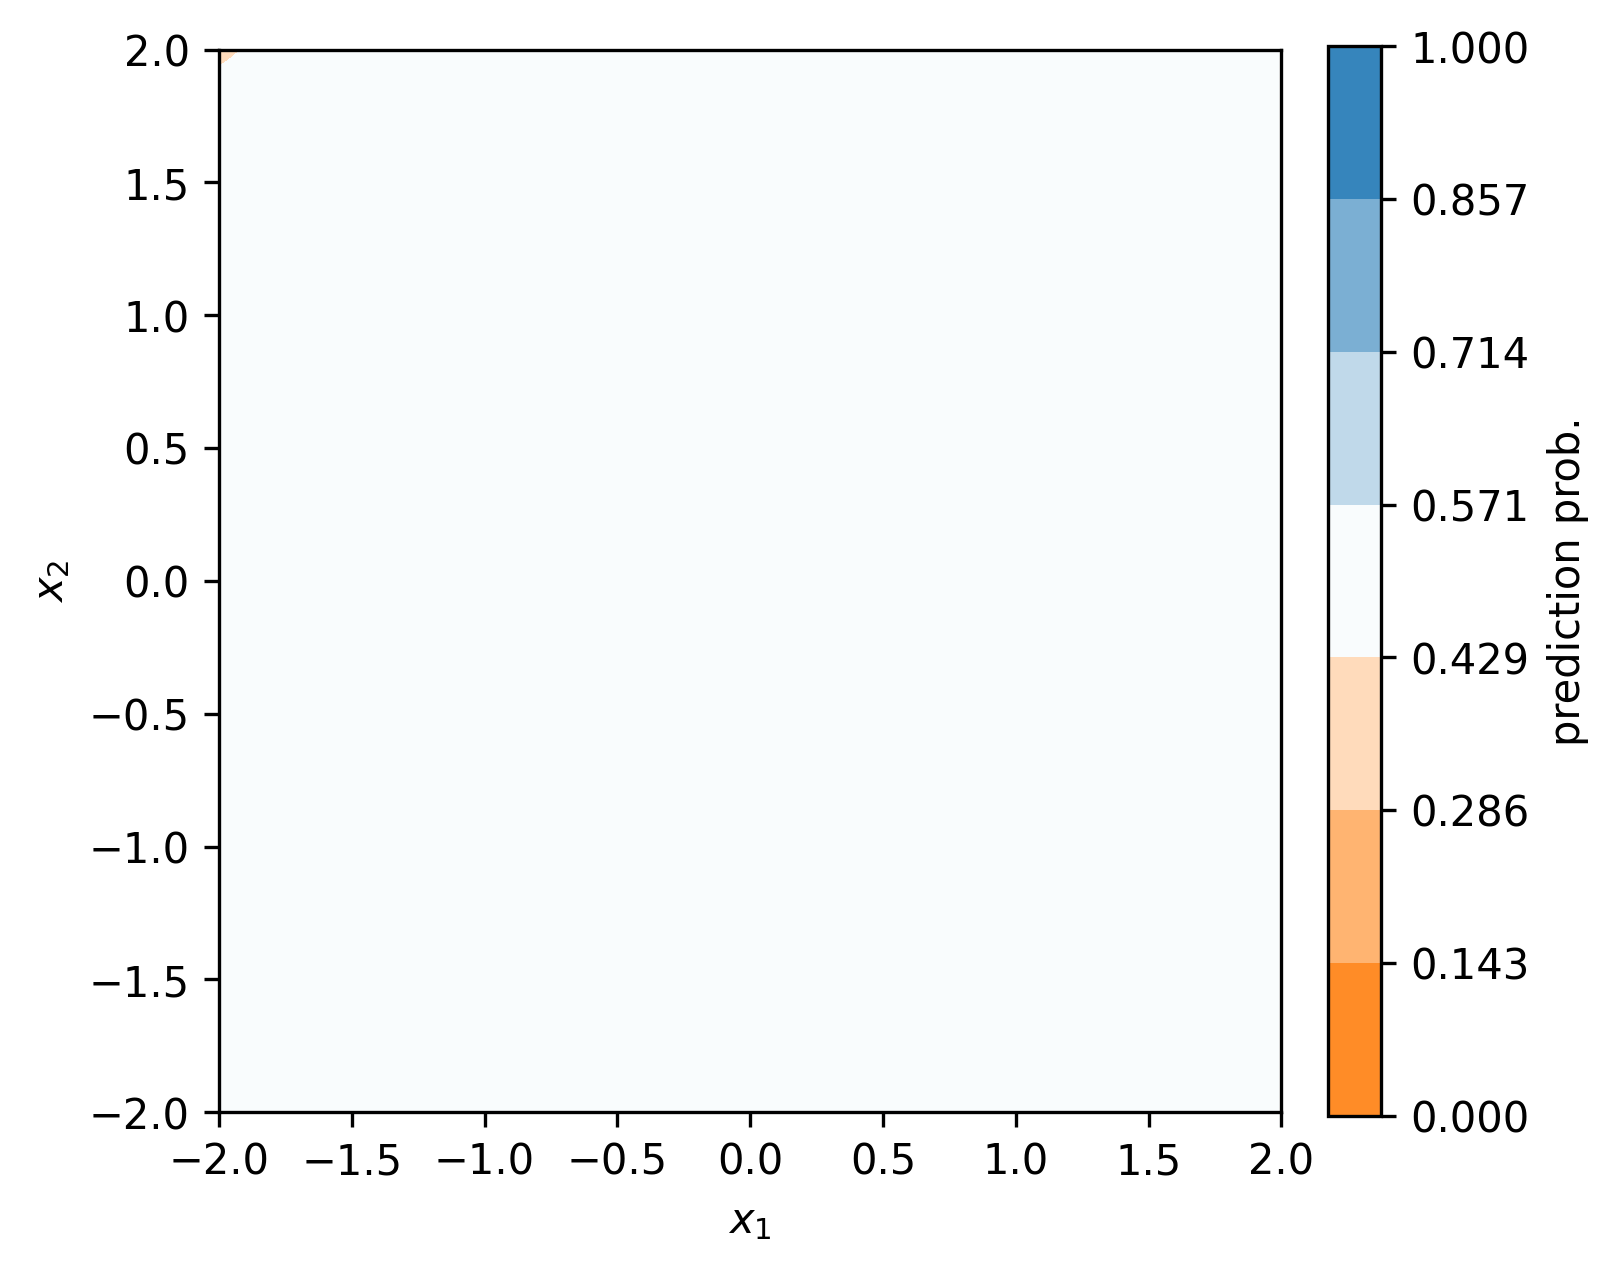

In [21]:
from plots.plots import classification_levelsets

classification_levelsets(anode, 'classification_levelsets')

from IPython.display import Image

img1 = Image(filename = 'classification_levelsets' + '.png', width = 400)
display(img1)

In [22]:
for X_viz, y_viz in dataloader_viz:
    X_viz = X_viz[0:5]
    break

trajectories = anode.flow.trajectory(X_viz, 10).detach()
print(X_viz)
print(trajectories.size()) #time is in the first coordinate

tensor([[ 1.6035, -1.6299],
        [ 0.0893,  1.5043],
        [-1.2083,  1.9876],
        [ 0.3064,  0.1923],
        [ 1.9054,  1.5809]])
torch.Size([10, 5, 2])


/Users/queirolo/Desktop/GIT_repository/BioML/models/neural_odes.py:110: UserWarning: Extending the dynamics
  warn('Extending the dynamics')
/Users/queirolo/Desktop/GIT_repository/BioML/models/neural_odes.py:110: UserWarning: Extending the dynamics
  warn('Extending the dynamics')


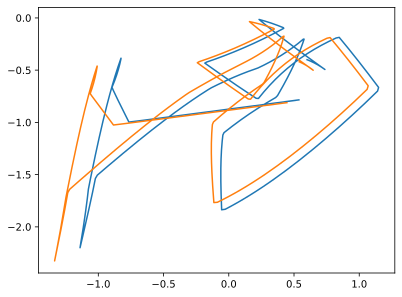

In [24]:
import scipy

def func(x,t):
    x_torch = torch.from_numpy(x).type(torch.float32)
    x_torch.requires_grad=True
    f_x_torch = anode.flow.dynamics.forward(t, x_torch)
    f_x_torch = f_x_torch.detach().numpy()
    return f_x_torch


x = np.array([0.6, -0.4])

x_torch = torch.from_numpy(x).type(torch.float32)

trajectories = anode.flow.trajectory(x_torch, 5000).detach()
x_t = scipy.integrate.odeint(func, x, np.linspace(0,20,500))

#plt.plot(trajectories[:,0],trajectories[:,1])
plt.plot(x_t[:,0],x_t[:,1])
#plt.show()

x = x - np.array([0.06, 0.02])
x_torch = torch.from_numpy(x).type(torch.float32)

#trajectories = anode.flow.trajectory(x_torch, 200).detach()

#plt.plot(trajectories[:,0],trajectories[:,1])
x_t = scipy.integrate.odeint(func, x, np.linspace(0,20,500))

#plt.plot(trajectories[:,0],trajectories[:,1])
plt.plot(x_t[:,0],x_t[:,1])

plt.show()

I want to visualize the separation boundary in the final linear layer.

In [25]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import torch
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
from matplotlib.colors import to_rgb
import imageio

from matplotlib.colors import LinearSegmentedColormap
import os


@torch.no_grad()
def linlayer_levelsets(model, fig_name=None, footnote=None, contour = True, plotlim = [-2, 2]):
    
    
    x1lower, x1upper = plotlim
    x2lower, x2upper = plotlim

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    fig = plt.figure(figsize=(5, 5), dpi=100)
    
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, 0, footnote, ha="center", fontsize=10)

    
   
    model.to(device)

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    
    preds = model.linear_layer(model_inputs)
    
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])

    ax = plt.gca()
    ax.set_aspect('equal') 
    
    if contour:
        colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
        cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)
        z = np.array(preds).reshape(xx1.shape)
        
        levels = np.linspace(0.,1.,20).tolist()
        
        cont = plt.contourf(xx1, xx2, z, levels, alpha=1, cmap=cm, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
        cbar = fig.colorbar(cont, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel('prediction prob.')
    

    if fig_name:
        plt.savefig(fig_name + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
        plt.clf()
        plt.close()
    # else: plt.show()

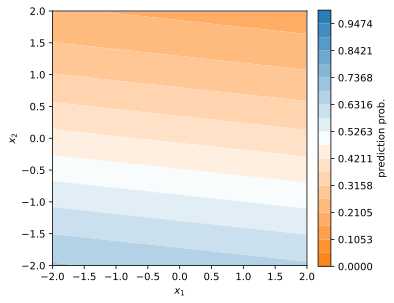

In [26]:
linlayer_levelsets(anode)

In [27]:
@torch.no_grad()
def trajectory_gif_new(model, inputs, targets, timesteps, dpi=200, alpha=0.9,
                   alpha_line=1, filename='trajectory.gif', axlim = 0):
    
    from matplotlib import rc
    from scipy.interpolate import interp1d
    rc("text", usetex = False)
    font = {'size'   : 18}
    rc('font', **font)

    if not filename.endswith(".gif"):
        raise RuntimeError("Name must end in with .gif, but ends with {}".format(filename))
    base_filename = filename[:-4]

    ## We focus on 3 colors at most
    if False in (t < 2 for t in targets): 
        color = ['mediumpurple' if targets[i] == 2.0 else 'gold' if targets[i] == 0.0 else 'mediumseagreen' for i in range(len(targets))]
    else:
        #color = ['crimson' if targets[i, 0] > 0.0 else 'dodgerblue' for i in range(len(targets))]
        color = ['C1' if targets[i] > 0.0 else 'dimgrey' for i in range(len(targets))]

    trajectories = model.flow.trajectory(inputs, timesteps).detach()
    num_dims = trajectories.shape[2]

    if axlim == 0:        
        x_min, x_max = trajectories[:, :, 0].min(), trajectories[:, :, 0].max()
        y_min, y_max = trajectories[:, :, 1].min(), trajectories[:, :, 1].max()
    else: 
        x_min, x_max = -axlim, axlim  #to normalize for rob and standard nODE
        y_min, y_max = -axlim, axlim   #
        
    if num_dims == 3:
        z_min, z_max = trajectories[:, :, 2].min(), trajectories[:, :, 2].max()
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= margin * x_range
    x_max += margin * x_range
    y_min -= margin * y_range
    y_max += margin * y_range
    if num_dims == 3:
        z_range = z_max - z_min
        z_min -= margin * z_range
        z_max += margin * z_range
        
    T = model.T 
    integration_time = torch.linspace(0.0, T, timesteps)
    
    interp_x = []
    interp_y = []
    interp_z = []
    for i in range(inputs.shape[0]):
        interp_x.append(interp1d(integration_time, trajectories[:, i, 0], kind='cubic', fill_value='extrapolate'))
        interp_y.append(interp1d(integration_time, trajectories[:, i, 1], kind='cubic', fill_value='extrapolate'))
        if num_dims == 3:
            interp_z.append(interp1d(integration_time, trajectories[:, i, 2], kind='cubic', fill_value='extrapolate'))
    
    interp_time = 20
    # interp_time = 3 #this was 5 before
    _time = torch.linspace(0., T, interp_time)

    plt.rc('grid', linestyle="dotted", color='lightgray')
    for t in range(interp_time):
        if num_dims == 2:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            label_size = 13
            plt.rcParams['xtick.labelsize'] = label_size
            plt.rcParams['ytick.labelsize'] = label_size 
            ax.set_axisbelow(True)
            ax.xaxis.grid(color='lightgray', linestyle='dotted')
            ax.yaxis.grid(color='lightgray', linestyle='dotted')
            ax.set_facecolor('whitesmoke')
            
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.rc('text', usetex=False)
            plt.rc('font', family='serif')
            plt.xlabel(r'$x_1$', fontsize=12)
            plt.ylabel(r'$x_2$', fontsize=12)
            
            x1 = torch.arange(x_min, x_max, step=0.01, device=device)
            x2 = torch.arange(y_min, y_max, step=0.01, device=device)
            xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
            model_inputs = torch.stack([xx1, xx2], dim=-1)
            
            preds = model.linear_layer(model_inputs)
            
            # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
            m = nn.Softmax(dim=2)
            # softmax normalizes the model predictions to probabilities
            preds = m(preds)

            #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
            preds = preds[:, :, 0]
            preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
            
            plt.grid(False)
    

            ax = plt.gca()
            ax.set_aspect('equal') 
            
            
            colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
            cm = LinearSegmentedColormap.from_list(
                "Custom", colors, N=40)
            z = np.array(preds).reshape(xx1.shape)
            
            levels = np.linspace(0.,1.,15).tolist()
            
            cont = plt.contourf(xx1, xx2, z, levels, alpha=0.5, cmap=cm, zorder = 0, extent=(x_min, x_max, y_min, y_max)) #plt.get_cmap('coolwarm')
            
            
            
            
            plt.scatter([x(_time)[t] for x in interp_x], 
                         [y(_time)[t] for y in interp_y], 
                         c=color, alpha=alpha, marker = 'o', linewidth=0.65, edgecolors='black', zorder=3)

            if t > 0:
                for i in range(inputs.shape[0]):
                    x_traj = interp_x[i](_time)[:t+1]
                    y_traj = interp_y[i](_time)[:t+1]
                    plt.plot(x_traj, y_traj, c=color[i], alpha=alpha_line, linewidth = 0.75, zorder=1)
            
        
        ax.set_aspect('equal')

        plt.savefig(base_filename + "{}.png".format(t),
                    format='png', dpi=dpi, bbox_inches='tight', facecolor = 'white')
        # Save only 3 frames (.pdf for paper)
        # if t in [0, interp_time//5, interp_time//2, interp_time-1]:
        #     plt.savefig(base_filename + "{}.pdf".format(t), format='pdf', bbox_inches='tight')
        plt.clf()
        plt.close()

    imgs = []
    for i in range(interp_time):
        img_file = base_filename + "{}.png".format(i)
        imgs.append(imageio.imread(img_file))
        if i not in [0, interp_time//5, interp_time//2, interp_time-1]: os.remove(img_file) 
    imageio.mimwrite(filename, imgs, duration = 500)

In [28]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

data_iter = iter(dataloader)
X,y = next(data_iter)
batch_size = 40

X_viz = torch.zeros_like(X[0:batch_size])
y_viz = torch.zeros(batch_size)
print(y_viz.size())
print(X_viz.size())
X_viz[:,1] = torch.linspace(-5,5,batch_size)
X_viz[:,0] = torch.tensor([0])
print(X_viz)

# plt.scatter(X_viz[:,0],X_viz[:,1])

trajectory_gif_new(anode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
trajectory_gif_new(rnode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)

torch.Size([40])
torch.Size([40, 2])
tensor([[ 0.0000, -5.0000],
        [ 0.0000, -4.7436],
        [ 0.0000, -4.4872],
        [ 0.0000, -4.2308],
        [ 0.0000, -3.9744],
        [ 0.0000, -3.7179],
        [ 0.0000, -3.4615],
        [ 0.0000, -3.2051],
        [ 0.0000, -2.9487],
        [ 0.0000, -2.6923],
        [ 0.0000, -2.4359],
        [ 0.0000, -2.1795],
        [ 0.0000, -1.9231],
        [ 0.0000, -1.6667],
        [ 0.0000, -1.4103],
        [ 0.0000, -1.1538],
        [ 0.0000, -0.8974],
        [ 0.0000, -0.6410],
        [ 0.0000, -0.3846],
        [ 0.0000, -0.1282],
        [ 0.0000,  0.1282],
        [ 0.0000,  0.3846],
        [ 0.0000,  0.6410],
        [ 0.0000,  0.8974],
        [ 0.0000,  1.1538],
        [ 0.0000,  1.4103],
        [ 0.0000,  1.6667],
        [ 0.0000,  1.9231],
        [ 0.0000,  2.1795],
        [ 0.0000,  2.4359],
        [ 0.0000,  2.6923],
        [ 0.0000,  2.9487],
        [ 0.0000,  3.2051],
        [ 0.0000,  3.4615],
        [ 0

/var/folders/nq/lv0cxwc9499c381g1gblftdm0000gn/T/ipykernel_76911/3109828661.py:141: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(img_file))


ValueError: all input arrays must have the same shape